In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [ ]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle= True)

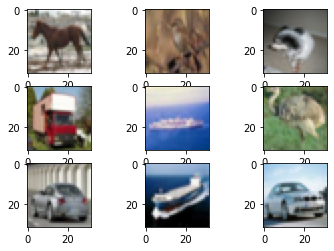

In [ ]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

In [ ]:
# scale pixels
def prep_pixels(train, test, valid):
	# convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  valid_norm = valid.astype('float32')
	# normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
	# return normalized images
  return train_norm, test_norm, valid_norm

# prepare pixel data
x_train, x_test, x_valid = prep_pixels(x_train, x_test, x_valid)

In [ ]:
from keras.layers.normalization import BatchNormalization

#Encoder architecture
encoder_input = layers.Input(shape=(32, 32, 3), name="encoder_input")
conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), activation='relu', padding='same', name="conv1")(encoder_input)
conv1bis = BatchNormalization()(conv1)
conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), activation='relu', padding='same', name="conv2")(conv1bis)
conv2 = BatchNormalization()(conv2)

conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', name="conv3")(conv2)
conv3 = BatchNormalization()(conv3)

conv4 = layers.Conv2D(128, 3, padding='same', name="conv4")(conv3)
conv4 = BatchNormalization()(conv4)

sum1 = layers.Add()([conv2, conv4])
conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(sum1)
conv5 = BatchNormalization()(conv5)

conv6 = layers.Conv2D(128, 3, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)

sum2 = layers.Add()([sum1, conv6])
conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(sum2)
conv7 = BatchNormalization()(conv7)

conv8 = layers.Conv2D(128, 3, padding='same')(conv7)
conv8 = BatchNormalization()(conv8)

sum3 = layers.Add()([sum2, conv8])
conv9 = layers.Conv2D(96, 5, strides=(2, 2), padding='same')(sum3)
conv9 = BatchNormalization()(conv9)

encoder_output = keras.backend.round(conv9)



In [ ]:
encoder = keras.Model(encoder_input, encoder_output, name='encoder_model')
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   4864        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 8, 8, 128)    204928      batch_normalization[0][0]        
______________________________________________________________________________________

In [ ]:
from keras.engine import Layer
import tensorflow as tf

class SubpixelConv2D(Layer):
    """ Subpixel Conv2D Layer
    upsampling a layer from (h, w, c) to (h*r, w*r, c/(r*r)),
    where r is the scaling factor, default to 4
    """

    def __init__(self, upsampling_factor=4, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of ' 
                             'integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        #return tf.depth_to_space( inputs, self.upsampling_factor )
        return tf.nn.depth_to_space( inputs, self.upsampling_factor )

    def get_config(self):
        config = { 'upsampling_factor': self.upsampling_factor, }
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor
        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor
        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor
        dims = [ input_shape[0],
                 input_shape_1,
                 input_shape_2,
                 int(input_shape[3]/factor)
               ]
        return tuple( dims )

In [ ]:
decoder_input = layers.Input(shape=(4, 4, 96), name="decoder_input")
conv1 = Conv2D(512, 3, padding='same')(decoder_input)
conv1 = BatchNormalization()(conv1)

subpix1 = SubpixelConv2D(2, name="decoder_subpix1")(conv1)
conv1 = BatchNormalization()(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same')(subpix1)
conv2 = BatchNormalization()(conv2)

conv3 = Conv2D(128, 3, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)

sum1 = layers.Add(name="decoder_sum1")([subpix1, conv3])
conv4 = Conv2D(128, 3, activation='relu', padding='same')(sum1)
conv4 = BatchNormalization()(conv4)

conv5 = Conv2D(128, 3, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)

sum2 = layers.Add(name="decoder_sum2")([sum1, conv5])
conv6 = Conv2D(128, 3, activation='relu', padding='same')(sum2)
conv6 = BatchNormalization()(conv6)

conv7 = Conv2D(128, 3, padding='same')(conv6)
conv7 = BatchNormalization()(conv7)

sum3 = layers.Add(name="decoder_sum3")([sum2, conv7])
conv8 = Conv2D(256, 3, padding='same')(sum3)
conv8 = BatchNormalization()(conv8)

subpix2 = SubpixelConv2D(2, name="decoder_subpix2")(conv8)
conv9 = BatchNormalization()(subpix2)

conv10 = Conv2D(12, 3, padding='same')(conv9)
conv10 = BatchNormalization()(conv10)

subpix3 = SubpixelConv2D(2, name="decoder_subpix3")(conv10)
conv11 = BatchNormalization()(subpix3)

decoder_output = keras.backend.clip(conv11, 0, 255)
#
decoder = keras.Model(decoder_input, decoder_output, name='decoder_model')

In [ ]:
decoder.summary()

Model: "decoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, 4, 4, 96)]   0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 4, 4, 512)    442880      decoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 4, 512)    2048        conv2d_5[0][0]                   
__________________________________________________________________________________________________
decoder_subpix1 (SubpixelConv2D (None, 8, 8, 128)    0           batch_normalization_9[0][0]      
______________________________________________________________________________________

In [ ]:
input_img = keras.Input(shape=(32, 32, 3))
ae_encoder_output = encoder(input_img)
ae_decoder_output = decoder( ae_encoder_output)

In [ ]:
ae = keras.models.Model(input_img, ae_decoder_output, name="AE")
ae.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 4, 4, 96)          1406816   
_________________________________________________________________
decoder_model (Functional)   (None, 32, 32, 3)         1636936   
Total params: 3,043,752
Trainable params: 3,038,410
Non-trainable params: 5,342
_________________________________________________________________


In [ ]:
import tensorflow.keras.optimizers  
ae.compile(loss='mse', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005))

ae.fit(x_train, x_train, epochs=5, batch_size=256, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/5
157/157 [==============================] - 752s 5s/step - loss: 0.0927 - val_loss: 14436.0029
Epoch 2/5
157/157 [==============================] - 741s 5s/step - loss: 0.0265 - val_loss: 8665.8760
Epoch 3/5
157/157 [==============================] - 736s 5s/step - loss: 0.0189 - val_loss: 4552.4766
Epoch 4/5
157/157 [==============================] - 740s 5s/step - loss: 0.0150 - val_loss: 2134.7771
Epoch 5/5
157/157 [==============================] - 737s 5s/step - loss: 0.0128 - val_loss: 1383.6653


In [ ]:
encoded_images = encoder.predict(x_train)
decoded_images = decoder.predict(encoded_images)

In [ ]:
encoded_images[1].size
decoded_images[1].size



3072

In [ ]:
decoded_images[0].size

3072

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


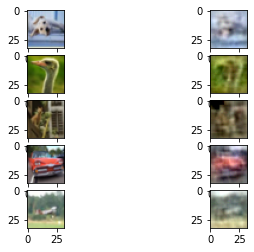

In [ ]:
import tensorflow.keras.datasets
import numpy

#decoded_images_orig = numpy.reshape(decoded_images,newshape=(decoded_images.shape[0],32,32))

import matplotlib
num_images_to_show = 5
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = numpy.random.randint(low=0, high=x_train.shape[0])
    matplotlib.pyplot.subplot(num_images_to_show, 2, plot_ind)
    matplotlib.pyplot.imshow(x_train[rand_ind, :, :], cmap="gray")
    matplotlib.pyplot.subplot(num_images_to_show, 2, plot_ind+1)
    matplotlib.pyplot.imshow(decoded_images[rand_ind, :, :], cmap="gray")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')